# Heart Disease Prediction - Model Training

This notebook focuses on training and evaluating multiple machine learning models for heart disease prediction.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('C:/Users/DELL/Desktop/heart-xai-chatbot/data/heart.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Define features and target
X = df.drop('HeartDisease', axis=1)  # Replace 'HeartDisease' with your target column
y = df['HeartDisease']

# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (734, 11)
Testing set shape: (184, 11)


## Model Training and Evaluation

We'll train and evaluate three different models:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [5]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"5-Fold CV ROC AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    return model, roc_auc

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib

# Define the categorical and numerical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']  # Update these column names based on your dataset
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Create a ColumnTransformer to apply preprocessing steps to numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_cols)   # One-Hot Encode categorical features
    ])

# Apply preprocessing and split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit the preprocessing pipeline on the training data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Save the preprocessor for later use (scaling + encoding)
joblib.dump(pipeline, 'C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/preprocessor.pkl')

# Optionally, if you want to save only the scaler part, you can extract it and save:
scaler = pipeline.named_steps['preprocessor'].transformers_[0][1]
joblib.dump(scaler, 'C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/scaler.pkl')



['C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/scaler.pkl']


Logistic Regression Performance:
Accuracy: 0.8859
Precision: 0.8716
Recall: 0.9314
F1 Score: 0.9005
ROC AUC: 0.9301
5-Fold CV ROC AUC: 0.9214 (±0.0330)


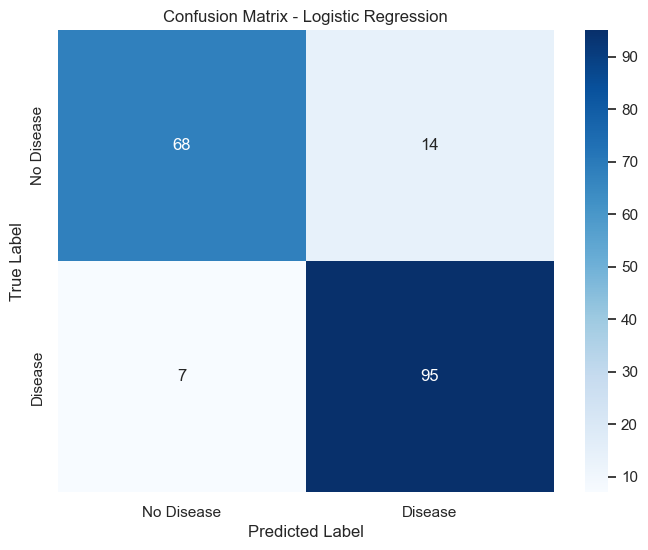

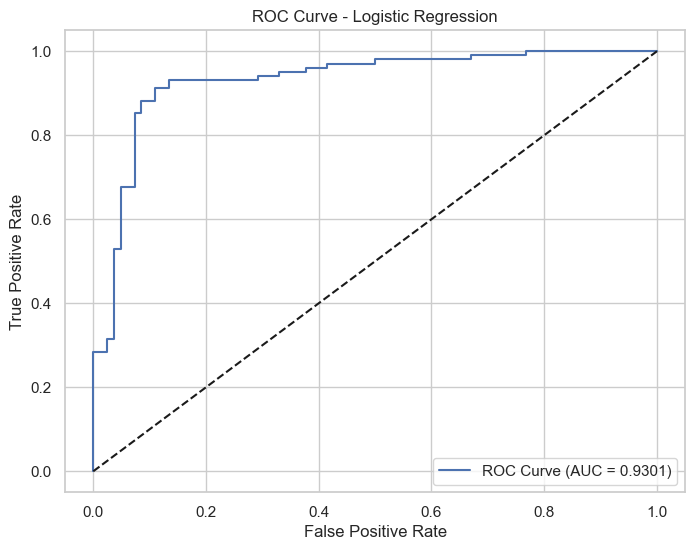

In [9]:
# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model, lr_auc = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")


Random Forest Performance:
Accuracy: 0.8913
Precision: 0.8942
Recall: 0.9118
F1 Score: 0.9029
ROC AUC: 0.9319
5-Fold CV ROC AUC: 0.9199 (±0.0227)


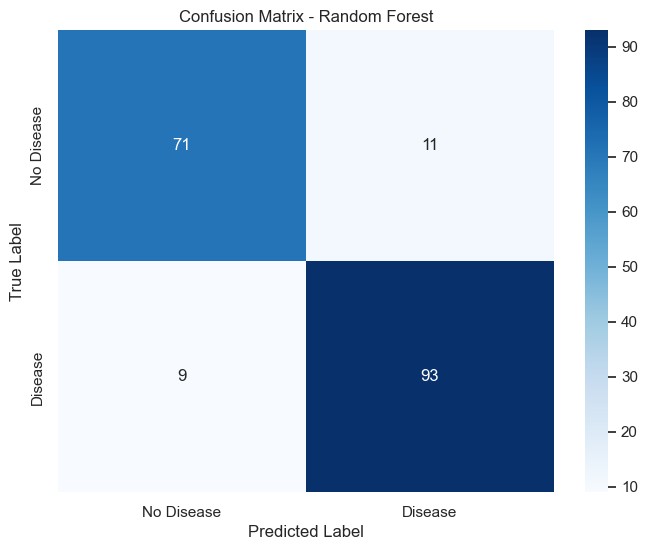

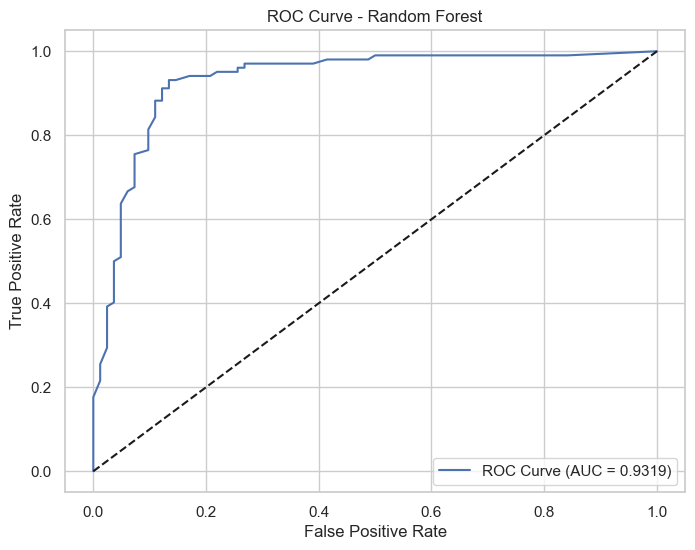

In [10]:
# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model, rf_auc = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")


XGBoost Performance:
Accuracy: 0.8587
Precision: 0.8958
Recall: 0.8431
F1 Score: 0.8687
ROC AUC: 0.9177
5-Fold CV ROC AUC: 0.9213 (±0.0172)


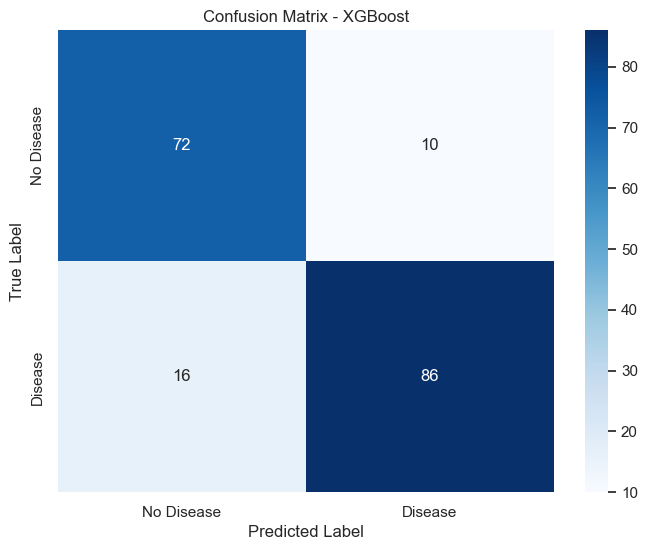

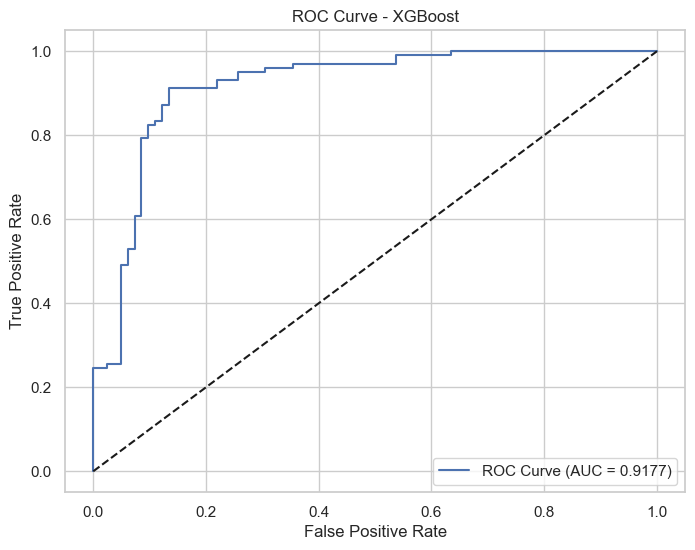

In [11]:
# 3. XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model, xgb_auc = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

Best hyperparameters for XGBoost:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Tuned XGBoost Performance:
Accuracy: 0.8913
Precision: 0.9100
Recall: 0.8922
F1 Score: 0.9010
ROC AUC: 0.9407
5-Fold CV ROC AUC: 0.9315 (±0.0186)


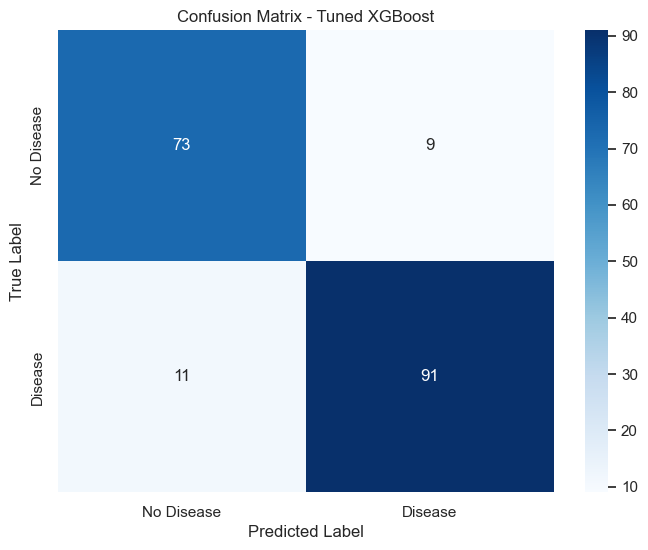

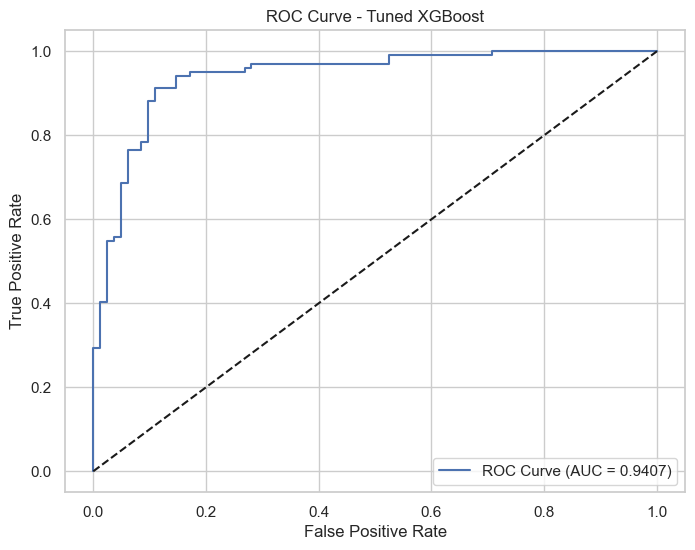

In [12]:
# Hyperparameter tuning for best model
# Let's assume XGBoost performed best (update based on actual results)
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid.fit(X_train_scaled, y_train)

print("Best hyperparameters for XGBoost:")
print(xgb_grid.best_params_)

# Evaluate the tuned model
best_xgb_model = xgb_grid.best_estimator_
_, best_xgb_auc = evaluate_model(best_xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Tuned XGBoost")

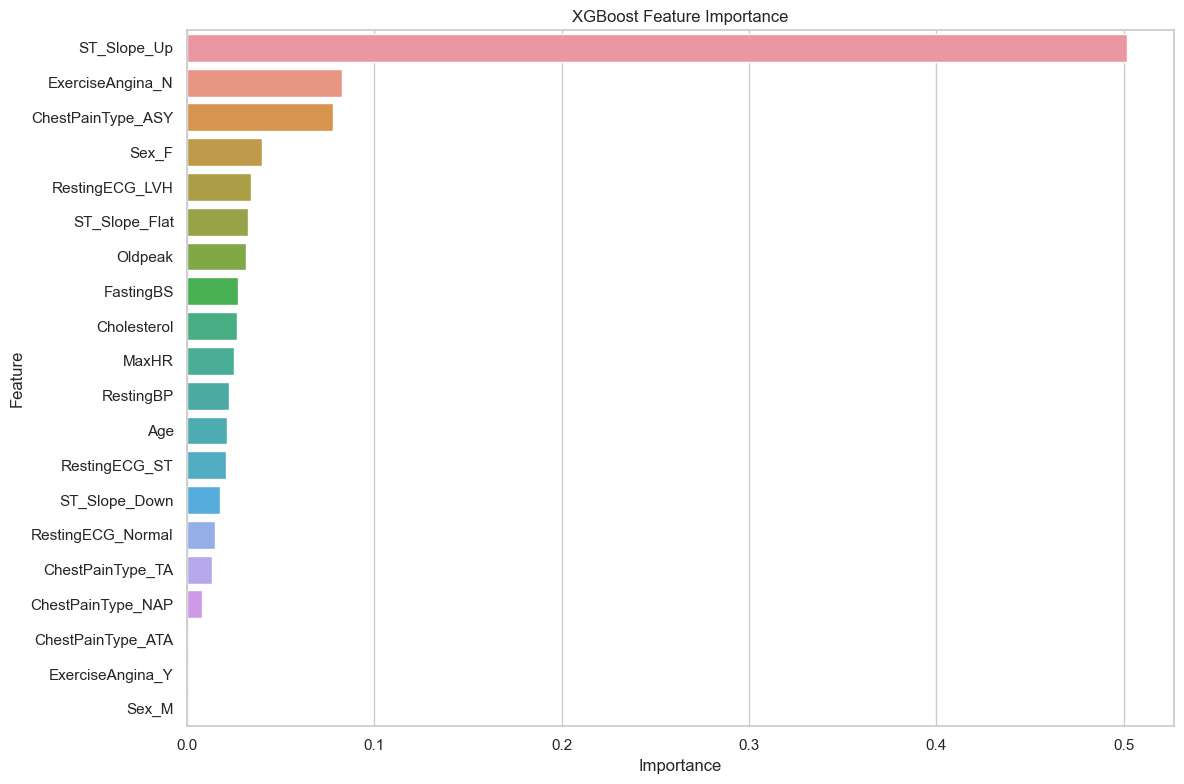

,Feature,Importance
19,ST_Slope_Up,0.501813
15,ExerciseAngina_N,0.083046
8,ChestPainType_ASY,0.078262
6,Sex_F,0.039947
12,RestingECG_LVH,0.034434
18,ST_Slope_Flat,0.032439
5,Oldpeak,0.031664
3,FastingBS,0.027533
2,Cholesterol,0.026662
4,MaxHR,0.025295


In [14]:
# First, get feature names after preprocessing
# Extract feature names from ColumnTransformer
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            # for OneHotEncoder
            names = transformer.get_feature_names_out(columns)
        else:
            # for StandardScaler
            names = columns
        output_features.extend(names)
    return output_features

# Now get feature names
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

# Create the feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

feature_importance


The best performing model is: Tuned XGBoost


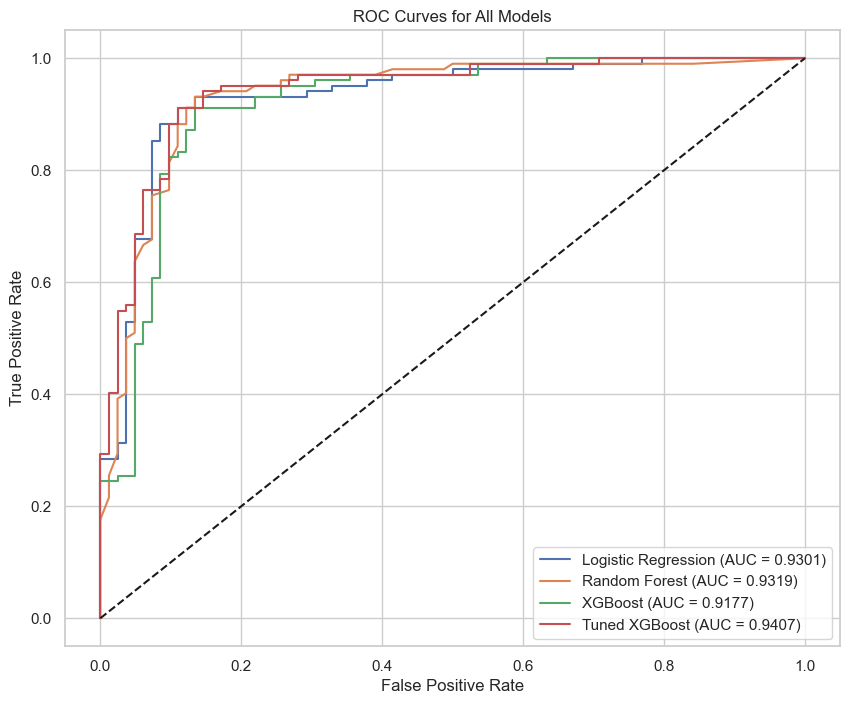

In [15]:
# Compare all models
models = {
    'Logistic Regression': (lr_model, lr_auc),
    'Random Forest': (rf_model, rf_auc),
    'XGBoost': (xgb_model, xgb_auc),
    'Tuned XGBoost': (best_xgb_model, best_xgb_auc)
}

# Find the best model
best_model_name = max(models.items(), key=lambda x: x[1][1])[0]
best_model = models[best_model_name][0]

print(f"\nThe best performing model is: {best_model_name}")

# Visualize ROC curves for all models
plt.figure(figsize=(10, 8))
for name, (model, _) in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Save the best model
joblib.dump(best_model, 'C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/model.pkl')
print(f"Saved {best_model_name} as 'model.pkl'")

# Also save feature names for later XAI use
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/model.pkl')
print("Saved feature names for XAI")

Saved Tuned XGBoost as 'model.pkl'
Saved feature names for XAI


## Model Training Summary

We've trained and compared multiple models for heart disease prediction:

1. **Logistic Regression**: A simple baseline model that performs reasonably well
2. **Random Forest**: A more complex ensemble model that handles non-linear relationships
3. **XGBoost**: A gradient boosting model that often achieves state-of-the-art performance
4. **Tuned XGBoost**: The XGBoost model with optimized hyperparameters

After hyperparameter tuning, the best model has been saved for deployment in our Heart Disease XAI application.

In the next notebook, we'll focus on implementing Explainable AI (XAI) techniques to help interpret the model's predictions.